# Intelligent Control (ECE-DK807)

## Electrical and Computer Engineering Department, University of Patras Greece

**Instructor:** Konstantinos Chazilygeroudis (costashatz@upatras.gr)

## Lab 4

### Q-learning with continuous states

In this lab, we will implement Q-learning but with continuous states and a Q-function approximator. We still need discrete actions. The algorithm goes as follows:

1. Initialize $Q_{\boldsymbol{\theta}}$
2. At every step:
   1. we observe the state $\boldsymbol{s}$
   2. we select and execute an action according to our policy $\boldsymbol{a}\sim\pi(\boldsymbol{s})$
   3. we end up at state $\boldsymbol{s}'$ and receive reward $r$
   4. $\boldsymbol{\Delta\theta} = \alpha\Big(r + \gamma\max_zQ_{\boldsymbol{\theta}}(\boldsymbol{s}',\boldsymbol{z}) - Q_{\boldsymbol{\theta}}(\boldsymbol{s},\boldsymbol{a})\Big)$


In [1]:
# Let's first import modules
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting
import copy
from collections import deque
import torch # neural networks (auto-diff)

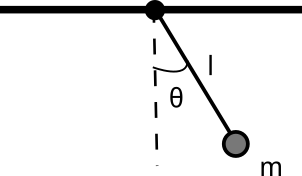

In [2]:
# Our system (pendulum)
def pendulum_dynamics(x, u):
    g = 9.81
    l = 1.
    m = 1.
    x_dot = np.concatenate([x[1:], -(g/l)*np.sin(x[:1]) + 1./(m*l*l)*u], axis=0)
    return x_dot

def pendulum_rk4(x, u, dt = 0.05):
    f1 = pendulum_dynamics(x, u)
    f2 = pendulum_dynamics(x + 0.5 * dt * f1, u)
    f3 = pendulum_dynamics(x + 0.5 * dt * f2, u)
    f4 = pendulum_dynamics(x + dt * f3, u)
    x_n = x + (dt/6.)*(f1 + 2. * f2 + 2. * f3 + f4)
    return x_n

In [3]:
def angle_dist(b, a):
    theta = b - a
    while theta < -np.pi:
        theta += 2. * np.pi
    while theta > np.pi:
        theta -= 2. * np.pi
    return theta

We will be using a neural network to model our Q-function. In particular, we are going to use a single hidden layer of ten neurons; we will use ReLU as the activation function for the hidden layer, and no activation in the output layer. We also have:

- The state of the system is $\boldsymbol{s} = \begin{bmatrix}\theta\\\dot{\theta}\end{bmatrix}$
- Since $\theta$ can wrap around, we will use as input to the Q-function the following transformed state: $\phi(\boldsymbol{s}) = \begin{bmatrix}\cos\theta\\\sin\theta\\\dot{\theta}\end{bmatrix}$
- Since we have discrete actions, we are going to use an **one-hot vector encoding** as input to the Q-function
- Thus, we have in total six (3 for the transformed state, 3 for the one-hot encoding) dimensions for the input to the Q-function

In [4]:
# Properties of the neural newtwork
N_input = 6 # (cosθ, sinθ, θdot) + one hot vector for actions
N_output = 1 # Output of the Q-function is a scalar
H = 10 # H hidden neurons

N_actions = 3 # we have 3 discrete actions

# MLP Model for the Q function
model = torch.nn.Sequential(
    ### TO-DO: Create the neural network described above
    ### ANSWER: Insert code here
    torch.nn.Linear(6, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1)
    ### END of ANSWER
)

def model_input(s, a):
    ### TO-DO: Compute the transformed input (that goes to the neural network) from raw state (s) and action (a)
    ### This function should work for batches, and it should return a torch.Tensor of size BxN where B is the batch size and N is the input dimension
    ### ANSWER: Insert code here
    (theta, theta_dot) = (s[:, 0], s[:, 1])
    (cos_theta, sin_theta) = (torch.cos(theta), torch.sin(theta))

    phi_s = torch.stack([cos_theta, sin_theta, theta_dot], dim = 1)

    if isinstance(a, int):    a = torch.tensor([a])
    elif isinstance(a, list): a = torch.tensor(a)
    one_hot_a = torch.nn.functional.one_hot(a, num_classes = N_actions)
    
    return torch.cat([phi_s, one_hot_a], dim = 1);
    ### END of ANSWER

def best_action(s):
    ### TO-DO: Select the best action given state, s, and the Q-function (global variable `model`)
    ### This function should work for batches, and it should return a torch.LongTensor of size B (batch_size)
    ### ANSWER: Insert code here
    B = s.size(0)
    
    q_values = []
    for a in range(N_actions):
        # https://pytorch.org/docs/stable/generated/torch.full.html
        a_tensor = torch.full((B, ), a)
        # https://pytorch.org/docs/stable/generated/torch.squeeze.html
        q_val = model(model_input(s, a_tensor)).squeeze(1)
        q_values.append(q_val)

    # For => TypeError: argmax(): argument 'input' (position 1) must be Tensor, not list
    q_values = torch.stack(q_values, dim = 1)
    
    return torch.argmax(q_values, dim = 1);
    ### END of ANSWER

# Policy given the Q-function
def pi(s, behavior="greedy", epsilon=0.1):
    ### ε-greedy policy
    if behavior == "greedy" or torch.rand(1).item() > epsilon:
        return best_action(s)
    return torch.LongTensor(torch.randint(low=0, high=N_actions, size=(s.size(0),)))

In [5]:
params = list(model.named_parameters())
assert(params[0][1].size() == torch.Size([10, 6]))
assert(params[2][1].size() == torch.Size([1, 10]))


In [6]:
torch.manual_seed(20) # Fixed seed for testing
s1 = torch.randn(1, 3)
a1 = 1
ss1 = torch.Tensor([[0.3567, -0.9342,  0.0617,  0.0000,  1.0000,  0.0000]])
assert(torch.isclose(model_input(s1, a1), ss1, rtol=1e-3).all())

s2 = torch.randn(20, 3)
a2 = torch.randint(low=0, high=N_actions, size=(s2.size(0),)).tolist()
ss2 = torch.Tensor([[ 0.8294, -0.5586, -2.1657,  0.0000,  1.0000,  0.0000], [ 0.6627,  0.7489, -0.5503,  0.0000,  1.0000,  0.0000], [-0.0240,  0.9997,  0.1684,  0.0000,  0.0000,  1.0000], [ 0.6888,  0.7249, -0.3083,  0.0000,  1.0000,  0.0000], [-0.6843, -0.7292,  0.6860,  0.0000,  1.0000,  0.0000], [ 0.3291,  0.9443,  0.7651,  1.0000,  0.0000,  0.0000], [ 0.7563, -0.6542, -0.7576,  0.0000,  1.0000,  0.0000], [-0.1378, -0.9905,  0.1217,  1.0000,  0.0000,  0.0000], [ 0.7118, -0.7024,  0.5549,  1.0000,  0.0000,  0.0000], [ 0.0938,  0.9956,  1.1124,  0.0000,  1.0000,  0.0000], [ 0.5568,  0.8306, -0.3072,  0.0000,  0.0000,  1.0000], [ 0.1985,  0.9801,  0.5297,  0.0000,  0.0000,  1.0000], [ 0.1421, -0.9898,  0.0087,  1.0000,  0.0000,  0.0000], [ 0.9687,  0.2483,  1.1616,  0.0000,  0.0000,  1.0000], [ 0.9855,  0.1696, -0.1926,  0.0000,  1.0000,  0.0000], [ 0.7119,  0.7023, -0.5311,  1.0000,  0.0000,  0.0000], [ 0.7004, -0.7137,  1.7783,  1.0000,  0.0000,  0.0000], [ 0.8719, -0.4898,  0.0803,  0.0000,  0.0000,  1.0000], [ 0.9995,  0.0302, -2.3601,  1.0000,  0.0000,  0.0000], [ 0.9856,  0.1692, -1.5470,  1.0000,  0.0000,  0.0000]])
assert(torch.isclose(model_input(s2, a2), ss2, rtol=1e-3, atol=1e-4).all())

s3 = torch.randn(30, 3)
a3 = torch.randint(low=0, high=N_actions, size=(s3.size(0),))
ss3 = torch.Tensor([[ 0.7581,  0.6522, -0.7197,  0.0000,  0.0000,  1.0000], [ 0.2446,  0.9696,  0.7110,  1.0000,  0.0000,  0.0000], [ 0.1876, -0.9823,  1.7299,  0.0000,  0.0000,  1.0000], [ 0.9712,  0.2385, -0.2449,  1.0000,  0.0000,  0.0000], [ 0.9858, -0.1678,  0.2678,  1.0000,  0.0000,  0.0000], [ 0.9980,  0.0626,  0.6465,  0.0000,  0.0000,  1.0000], [ 0.6184, -0.7859, -1.8551,  0.0000,  1.0000,  0.0000], [ 0.9370, -0.3493, -0.3016,  1.0000,  0.0000,  0.0000], [ 0.8257,  0.5641, -2.5927,  1.0000,  0.0000,  0.0000], [ 0.7754,  0.6315,  0.8004,  0.0000,  0.0000,  1.0000], [-0.2842, -0.9588, -2.5038,  0.0000,  1.0000,  0.0000], [ 0.9972, -0.0741,  1.0900,  0.0000,  0.0000,  1.0000], [ 0.9985, -0.0552,  0.6968,  1.0000,  0.0000,  0.0000], [ 0.9654, -0.2609,  1.2086,  0.0000,  1.0000,  0.0000], [ 0.8110, -0.5851,  0.8551,  0.0000,  1.0000,  0.0000], [ 0.8831, -0.4693, -0.0717,  0.0000,  0.0000,  1.0000], [-0.1258, -0.9921,  0.2936,  0.0000,  1.0000,  0.0000], [ 0.7526, -0.6585, -1.1449,  0.0000,  0.0000,  1.0000], [ 0.4615, -0.8871,  1.1617,  0.0000,  1.0000,  0.0000], [ 0.7045,  0.7097,  0.5226,  0.0000,  0.0000,  1.0000], [ 0.5474, -0.8369,  0.0080,  0.0000,  1.0000,  0.0000], [ 0.9899,  0.1415, -0.3260,  0.0000,  0.0000,  1.0000], [ 0.6291,  0.7773,  0.4013,  0.0000,  1.0000,  0.0000], [ 0.0942, -0.9956,  0.0690,  0.0000,  0.0000,  1.0000], [ 0.9950, -0.1000,  1.0036,  0.0000,  0.0000,  1.0000], [ 0.9875,  0.1573, -0.5776,  1.0000,  0.0000,  0.0000], [ 0.8383, -0.5452, -1.6220,  0.0000,  1.0000,  0.0000], [ 0.4719, -0.8817, -1.5315,  0.0000,  0.0000,  1.0000], [-0.7442, -0.6679, -0.7238,  1.0000,  0.0000,  0.0000], [ 0.2234, -0.9747,  0.6636,  1.0000,  0.0000,  0.0000]])
assert(torch.isclose(model_input(s3, a3), ss3, rtol=1e-3, atol=1e-4).all())

In [7]:
torch.manual_seed(40) # Fixed seed for testing
old_params = torch.nn.utils.parameters_to_vector(model.parameters())
params = torch.randn_like(old_params)
torch.nn.utils.vector_to_parameters(params, model.parameters())

s1 = torch.randn(1, 3)
assert(best_action(s1).item() == 1)

s2 = torch.randn(20, 3)
o1 = torch.LongTensor([1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1])
assert(torch.isclose(best_action(s2), o1).all())

s3 = torch.randn(30, 3)
o2 = torch.LongTensor([1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1])
assert(torch.isclose(best_action(s3), o2).all())

torch.nn.utils.vector_to_parameters(old_params, model.parameters())

We will be using the Adam optimizer, $\gamma=1$ and $\epsilon=0.1$.

In [8]:
# create an optimizer
learning_rate = 5e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# initialize gamma and stats
gamma = 1.
epsilon = 0.1
n_episode = 1
returns = deque(maxlen=200)

Let's now create a function `run_episode` that runs a full episode starting from $x_{init}$ and uses the current policy/Q-function. It also updates the Q-function per step if asked.

In [9]:
def run_episode(x_init, epsilon = 0.1, update = True):
    ### The function runs a full episode starting from $x_{init}$
    ### `epsilon` should be used for the ε-greedy policy
    ### if `update` is True, then we should use the Q-learning update rule to update the model at each timestep
    # Max torque/velocity
    max_torque = 2.
    max_vel = 3.

    states = []
    actions = []
    rewards = []
    # reset environment
    x_pendulum = np.copy(x_init)

    n_steps = 0
    while True:
        state = torch.Tensor(x_pendulum).reshape((1, -1)) # current state to torch.Tensor
        ### TO-DO: Use the policy (`pi` function) to get a stochastic (ε-greedy policy) action.
        ### You should store the result in a variable named `action`
        ### ANSWER: Insert code here
        action = pi(state, "stochastic", epsilon)
        ### END of ANSWER

        # use that action in the environment
        u = 0.
        if action.item() == 1:
            u = max_torque
        elif action.item() == 2:
            u = -max_torque
        # step the environment
        x_new = pendulum_rk4(x_pendulum, u)
        x_new[1, 0] = max(-max_vel, min(max_vel, x_new[1, 0]))
        reward = 1.
        done = abs(angle_dist(np.pi, x_new[0, 0])) > 0.349066
        # store reward
        rewards.append(reward)

        ### TO-DO: Update Q-function if asked
        if update:
            ### TO-DO: Write the Q-learning update as described in the algorithm
            ### ANSWER: Insert code here
            next_state = torch.Tensor(x_new).reshape((1, -1))

            with torch.no_grad(): # αφού υπολογίζουμε τον στόχο!
                q_max = max(
                    model(model_input(next_state, candidate_action))
                    for candidate_action in range(N_actions)
                )
                target = reward + gamma * q_max * int(not done)
        
            q_current = model(model_input(state, action))
            loss = (q_current - target) * (q_current - target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ### END of ANSWER
        states.append(state)
        actions.append(action.item())

        x_pendulum = np.copy(x_new)

        if n_steps > 80 or done:
            break
        n_steps += 1

    return rewards;

In [10]:
torch.manual_seed(90) # Fixed seed for testing
old_params = torch.nn.utils.parameters_to_vector(model.parameters())
params = torch.randn_like(old_params)
torch.nn.utils.vector_to_parameters(params, model.parameters())

x_init = np.array([[np.pi, 0.]]).T
rw = run_episode(x_init, update=False)
assert(len(rw) == 21)
assert(sum(rw) == 21)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

rw = run_episode(x_init, update=True)
assert(len(rw) == 67)
assert(sum(rw) == 67)

final_params = torch.nn.utils.parameters_to_vector(model.parameters())
assert(torch.isclose(torch.sum(final_params), torch.Tensor([-5.02]), rtol=1e-2))

torch.nn.utils.vector_to_parameters(old_params, model.parameters())

In [11]:
# Let's run the Q-learning procedure
# reset Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

x_pendulum = np.array([[np.pi, 0.]]).T
x_init = np.copy(x_pendulum)

all_returns = []
smoothed_returns = []
smoothed_return = None
max_steps = 500 * 82
total_steps = 0
while total_steps < max_steps:
    rewards = run_episode(x_init, epsilon, True)
    total_steps += len(rewards)

    # preprocess rewards
    rewards = np.array(rewards)
    all_returns += [np.sum(rewards)]
    alpha = 0.6
    if smoothed_return is None:
        smoothed_return = all_returns[-1]
    smoothed_return = alpha * smoothed_return + (1. - alpha) * all_returns[-1]
    smoothed_returns += [smoothed_return]

    # calculate average return and print it out
    returns.append(np.sum(rewards))
    if n_episode % 200 == 0 or n_episode == 1:
        print("Episode: {:6d}\tAvg. Return: {:6.2f}\tSteps: {:6d}".format(n_episode, np.mean(returns), total_steps))
    n_episode += 1

Episode:      1	Avg. Return:  11.00	Steps:     11
Episode:    200	Avg. Return:  36.50	Steps:   7300
Episode:    400	Avg. Return:  50.60	Steps:  17421
Episode:    600	Avg. Return:  65.78	Steps:  30578


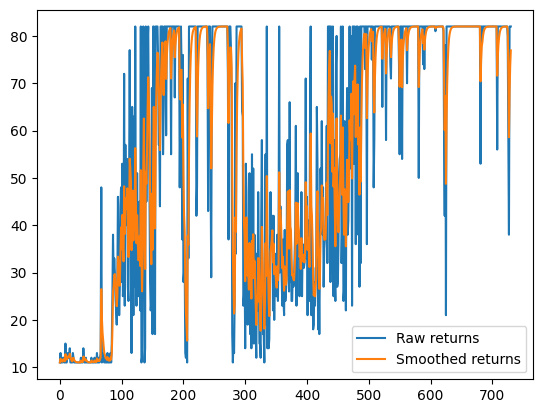

In [12]:
# Plot learning curve
fig, ax = plt.subplots(1, 1)

xx = np.arange(len(all_returns))

ax.plot(xx, all_returns, label="Raw returns")
ax.plot(xx, smoothed_returns, label="Smoothed returns")

ax.legend()

plt.show()

In [13]:
# Run episode without exploration
rewards = run_episode(x_init, 0., False)

print(np.sum(rewards))

82.0
